In [ ]:
import os
import time
import h5py
import scipy
import timeit
import pyfftw
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt  
import matplotlib.ticker as mticker

from jax import jit
from tqdm import tqdm
from mpmath import mpf
from scipy.fft import fftfreq, fftn, ifftn, rfftn, rfftfreq
from matplotlib import animation
from scipy.special import k0, k1
from tqdm.notebook import tqdm, trange
from scipy.interpolate import RegularGridInterpolator, interpn
from matplotlib.animation import FuncAnimation 
from matplotlib.animation import PillowWriter
from matplotlib.animation import FFMpegWriter

from ULDM_Simulator import *
from util import *

plt.rcParams['text.usetex'] = True
plt.style.use('./myplot.mplstyle')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ultralight Dark Matter

In [2]:
sim = ULDM_Simulator(L=32, kJ=1e-3)
sim.solve()

  0%|          | 0/4096 [00:00<?, ?it/s]

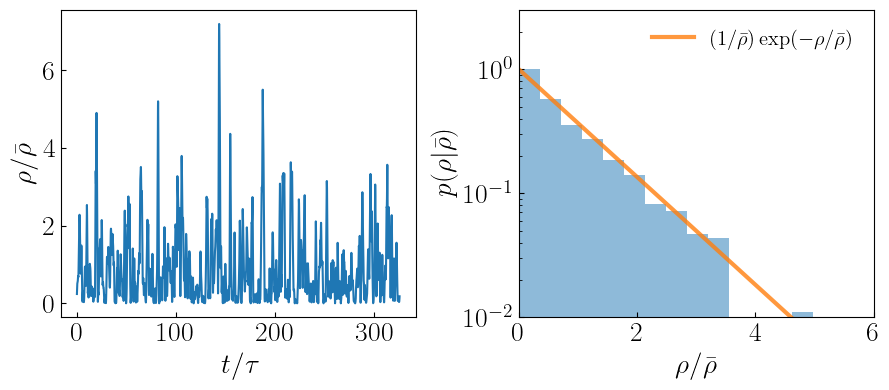

In [7]:
sim_plot = Plotting(sim)
sim_plot.rho_plot();

# Free Particle

In [ ]:
class Utility():
    
    def __init__(self, sim_data):
        self.data = sim_data
        self.pos_arr = self.data.pos_arr
        self.vel_arr = self.data.vel_arr
        self.acc_arr = self.data.acc_arr
        self.time = self.data.time
        self.T = self.data.T
        self.dt = self.data.dt
        self.kJ = self.data.kJ

    def plot_PS(self, 
                window=[True,False], 
                each=[False,False],
                alpha=0.5,
                subtracted=False,
                ):
        '''
        Plot Power Spectrum and
        Compare with analytic result
        '''
        if not subtracted:
            x = self.pos_arr[:, 0]
            y = self.pos_arr[:, 1]
            z = self.pos_arr[:, 2]

            ax = self.acc_arr[:, 0]
            ay = self.acc_arr[:, 1]
            az = self.acc_arr[:, 2]
        else:
            x = self.data.x_sub
            y = self.pos_arr[:, 1]
            z = self.pos_arr[:, 2]
            ax = self.data.a_sub
            ay = self.acc_arr[:, 1]
            az = self.acc_arr[:, 2]

        if window[0]:
            window_func = np.sin(np.pi * self.time / self.T)**8 * (128/35)
            x = x * window_func
            y = y * window_func
            z = z * window_func
            
        if window[1]:
            window_func = np.sin(np.pi * self.time / self.T)**8 * (128/35)
            ax = ax * window_func
            ay = ay * window_func
            az = az * window_func
        
        self.ps_x = (self.dt**2 / self.T) * np.abs(fftn(x))**2
        self.ps_z = (self.dt**2 / self.T) * np.abs(fftn(y))**2
        self.ps_y = (self.dt**2 / self.T) * np.abs(fftn(z))**2

        self.ps_ax = (self.dt**2 / self.T) * np.abs(fftn(ax))**2
        self.ps_ay = (self.dt**2 / self.T) * np.abs(fftn(ay))**2
        self.ps_az = (self.dt**2 / self.T) * np.abs(fftn(az))**2
        
        self.freq = fftfreq(len(self.time), self.dt)
        
        n = len(self.time)//2

        fig, ax = plt.subplots(ncols=2, figsize=(9,4))

        avg_PS_x = (self.ps_x[:n] + self.ps_y[:n] + self.ps_z[:n]) / 3
        avg_PS_a = (self.ps_ax[:n] + self.ps_ay[:n] + self.ps_az[:n]) / 3
        
        if each[0]:
            ax[0].plot(self.freq[:n], self.ps_x[:n], 'x', alpha=alpha, label=r'$x$')
            ax[0].plot(self.freq[:n], self.ps_y[:n], '+', alpha=alpha, label=r'$y$')
            ax[0].plot(self.freq[:n], self.ps_z[:n], '.', alpha=alpha, label=r'$z$')
            ax[0].legend()
        else:
            ax[0].plot(self.freq[:n], avg_PS_x, '.')
        ax[0].plot(self.freq[:n], self.Sx(self.freq[:n]), lw=5, alpha=0.5)
        ax[0].set_xscale('log')
        ax[0].set_yscale('log')
        ax[0].set_xlabel(r'$\textrm{Frequency [Hz]}$')
        ax[0].set_ylabel(r'${\rm PSD}_x$')
        ax[0].set_ylim(max(1e-3 * min(avg_PS_x), self.Sx(5)), 10 * max(avg_PS_x))

        if each[1]:
            ax[1].plot(self.freq[:n], self.ps_ax[:n], 'x', alpha=alpha, label=r'$a_x$')
            ax[1].plot(self.freq[:n], self.ps_ay[:n], '+', alpha=alpha, label=r'$a_y$')
            ax[1].plot(self.freq[:n], self.ps_az[:n], '.', alpha=alpha, label=r'$a_z$')
            ax[1].legend()
        else:
            ax[1].plot(self.freq[:n], avg_PS_a, '.')
        ax[1].plot(self.freq[:n], self.Sa(self.freq[:n]), lw=5, alpha=0.5)
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[1].set_xlabel(r'$\textrm{Frequency [Hz]}$')
        ax[1].set_ylabel(r'${\rm PSD}_a$')
        ax[1].set_ylim(max(1e-3 * min(avg_PS_a), self.Sa(5)), 10 * max(avg_PS_a))
        
        fig.tight_layout()
        return fig;

    def Sa(self, f: list[float]):
        '''
        Analytic spectrum S_a(f)
        Input
            f (ndarray (n,))    frequency array
        '''

        # In this simulation we measure time in coherence time
        # and frequency in inverse of coherence time
        tau = 1
        return (self.kJ**8 / 16) * k0(np.abs(2 * np.pi * f * tau)) * tau / 3
    
    def Sx(self, f: list[float], f0=0):
        '''
        Analytic spectrum S_x(f)
        Input
            f (ndarray (n,))    frequency array
        '''

        # In this simulation we measure time in coherence time
        # and frequency in inverse of coherence time
        tau = 1 
        return self.Sa(f) / (2 * np.pi * (f + f0) * tau)**4

In [8]:
sim_FP = ULDM_FreeParticle(L=32, kJ=1e-3)
sim_FP.solve()

  0%|          | 0/4096 [00:00<?, ?it/s]

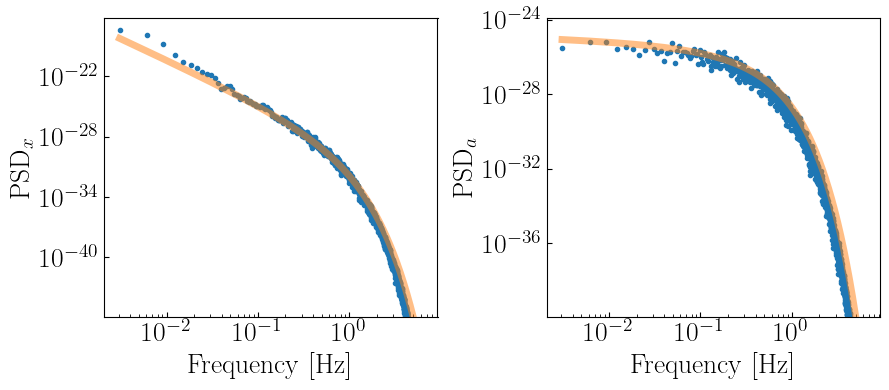

In [14]:
util = Utility(sim_FP)
fig = util.plot_PS(window=[True,False]);
# fig.savefig('./figs/freeParticlePSD.pdf')

# Harmonic Oscillator

In [526]:
sim_HO = ULDM_HarmonicOscillator(L=32, kJ=1e-3, f_osc=2e-1)
sim_HO.solve()

100%|██████████| 4096/4096 [04:26<00:00, 15.37it/s]


In [546]:
sim_HO.subtract()

In [624]:
plot_HO = Utility(sim_HO)

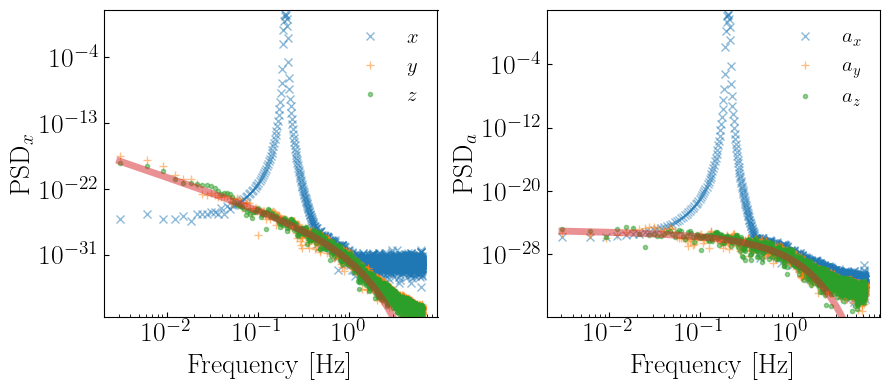

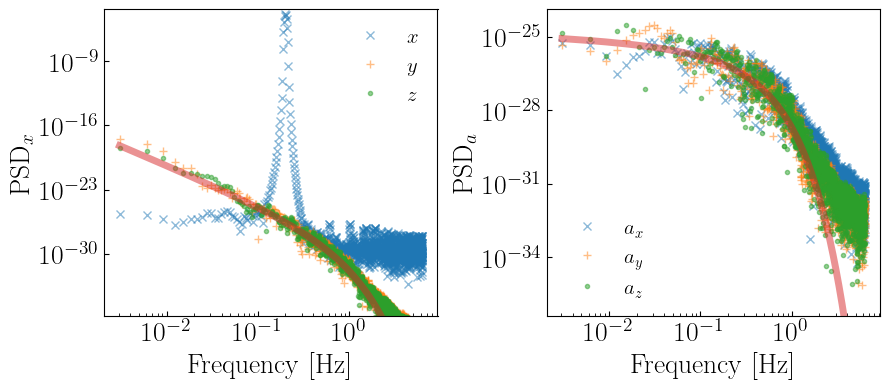

In [627]:
fig = plot_HO.plot_PS(window=[True,True],
                      each=[True,True],
                      subtracted=False);

fig.savefig('./figs/SHO_before_subtraction.pdf')

fig = plot_HO.plot_PS(window=[True,True],
                      each=[True,True],
                      subtracted=True);

fig.savefig('./figs/SHO_after_subtraction.pdf')

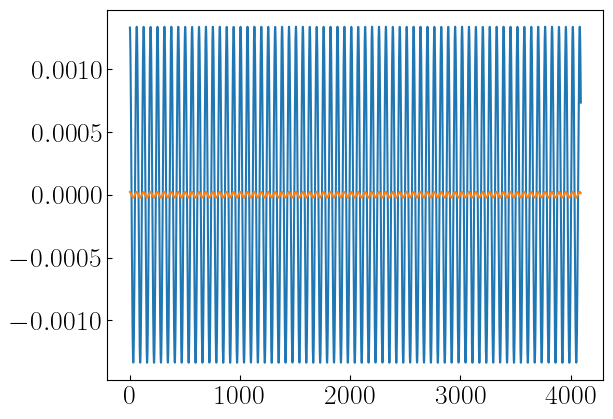

In [659]:
acc_from_pos0 = np.array([sim_HO.pos_arr[i+1,0] - 2 * sim_HO.pos_arr[i,0] + sim_HO.pos_arr[i-1,0] for i in range(1, len(sim_HO.time)-1)]) / (sim_HO.dt**2)
acc_from_pos = np.array([sim_HO.pos_arr[i+1,0] - 2 * sim_HO.pos_arr[i,0] + sim_HO.pos_arr[i-1,0] for i in range(1, len(sim_HO.time)-1)]) / (sim_HO.dt**2)
acc_from_pos = acc_from_pos + (2 * np.pi * sim_HO.f_osc)**2 * sim_HO.pos_arr[1:-1,0]
# plt.plot(sim_HO.acc_arr[:,0])

acc_from_pos2 = np.array([- 1 / 12 * sim_HO.pos_arr[i+2,0] 
                          + 4 / 3 * sim_HO.pos_arr[i+1,0] 
                          - 5 / 2 * sim_HO.pos_arr[i,0] 
                          + 4 / 3 * sim_HO.pos_arr[i-1,0] 
                          - 1 / 12 * sim_HO.pos_arr[i-2,0] for i in range(2, len(sim_HO.time)-2)]) / (sim_HO.dt**2)
acc_from_pos2 = acc_from_pos2 + (2 * np.pi * sim_HO.f_osc)**2 * sim_HO.pos_arr[2:-2,0]

plt.plot(acc_from_pos)
plt.plot(acc_from_pos2)

In [653]:
wd = np.sin(np.pi * sim_HO.time / (sim_HO.T))**8 * (128/35)
wd1 = np.sin(np.pi * sim_HO.time[1:-1] / (sim_HO.T - sim_HO.dt * 2))**8 * (128/35)
wd2 = np.sin(np.pi * sim_HO.time[2:-2] / (sim_HO.T - sim_HO.dt * 4))**8 * (128/35)
pre = (sim_HO.dt**2 / sim_HO.T)

freq = fftfreq(len(sim_HO.time), sim_HO.dt)

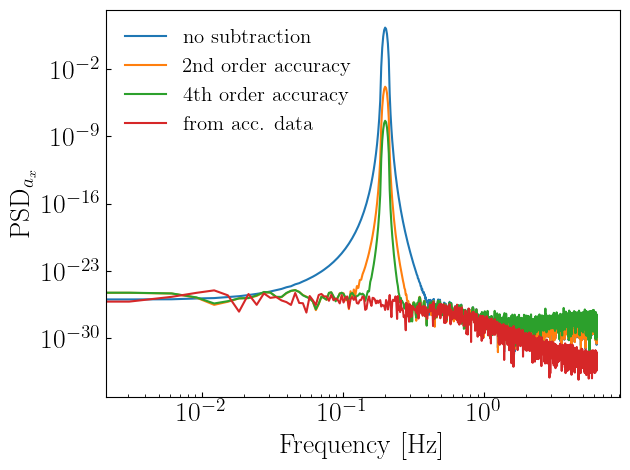

In [ ]:
fig, ax = plt.subplots()

ax.plot(freq[:len(acc_from_pos0)//2], pre * (np.abs(fftn(acc_from_pos0*wd1))**2)[:len(acc_from_pos0)//2],
        label=r'\textrm{no subtraction}')
ax.plot(freq[:len(acc_from_pos)//2], pre * (np.abs(fftn(acc_from_pos*wd1))**2)[:len(acc_from_pos)//2],
        label=r'\textrm{2nd order accuracy}')
ax.plot(freq[:len(acc_from_pos2)//2], pre * (np.abs(fftn(acc_from_pos2*wd2))**2)[:len(acc_from_pos2)//2],
        label=r'\textrm{4th order accuracy}')
ax.plot(freq[:len(acc_from_pos)//2], pre * (np.abs(fftn(sim_HO.a_sub))**2)[:len(acc_from_pos)//2],
        label=r'\textrm{from acc. data}')

ax.set_xlabel(r'$\textrm{Frequency [Hz]}$')
ax.set_ylabel(r'$\textrm{PSD$_{a_x}$}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
# fig.savefig('./figs/SHO_fd.pdf')

In [111]:
my_res = np.random.normal(size=1000)

In [112]:
my_res.shape

(1000,)

In [113]:
my_res_new = np.mean(my_res.reshape(-1,10), axis=1)
dt=20
my_res_new2 = np.mean(my_res.reshape(-1, dt), axis=1)

In [114]:
my_acc = [my_res[i+1] - 2 * my_res[i] + my_res[i-1] for i in range(1, len(my_res)-1)]
my_acc2 = [-1/12 * my_res[i+2] + 4 / 3 * my_res[i+1] - 5 / 2 * my_res[i] + 4 / 3 * my_res[i-1] - 1 / 12 * my_res[i-2] for i in range(2, len(my_res)-2)]
my_acc3 = 1e-2 * np.array([my_res_new[i+1] - 2 * my_res_new[i] + my_res_new[i-1] for i in range(1, len(my_res_new)-1)])
my_acc4 = dt**-2 * np.array([my_res_new2[i+1] - 2 * my_res_new2[i] + my_res_new2[i-1] for i in range(1, len(my_res_new2)-1)])

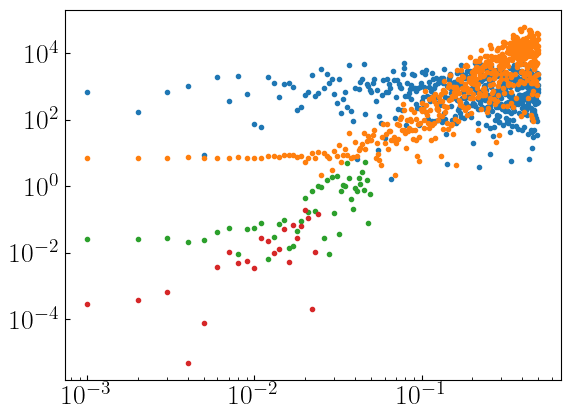

In [115]:
n = len(my_res)//2
n2 = len(my_res_new)//2
n3 = len(my_res_new2)//2
freq= fftfreq(len(my_res))[:n]
freq2= fftfreq(len(my_res_new),d=10)[:n2]
freq3= fftfreq(len(my_res_new2),d=dt)[:n3]

plt.plot(freq, (np.abs(fftn(my_res))**2)[:n], '.')
plt.plot(freq, (np.abs(fftn(my_acc))**2)[:n], '.')
plt.plot(freq2, 100*(np.abs(fftn(my_acc3))**2)[:n2], '.')
plt.plot(freq3, dt**2*(np.abs(fftn(my_acc4))**2)[:n3], '.')
# plt.plot(freq, (np.abs(fftn(my_acc2))**2)[:n], '.')
plt.xscale('log')
plt.yscale('log')

# Orbital Simulation

In [432]:
print(np.finfo(np.longdouble), np.finfo(np.float128))

Machine parameters for float128
---------------------------------------------------------------
precision =  18   resolution = 1.0000000000000000715e-18
machep =    -63   eps =        1.084202172485504434e-19
negep =     -64   epsneg =     5.42101086242752217e-20
minexp = -16382   tiny =       3.3621031431120935063e-4932
maxexp =  16384   max =        1.189731495357231765e+4932
nexp =       15   min =        -max
smallest_normal = 3.3621031431120935063e-4932   smallest_subnormal = 4e-4951
---------------------------------------------------------------
 Machine parameters for float128
---------------------------------------------------------------
precision =  18   resolution = 1.0000000000000000715e-18
machep =    -63   eps =        1.084202172485504434e-19
negep =     -64   epsneg =     5.42101086242752217e-20
minexp = -16382   tiny =       3.3621031431120935063e-4932
maxexp =  16384   max =        1.189731495357231765e+4932
nexp =       15   min =        -max
smallest_normal = 3.3621

In [647]:
class ULDM_Orbital(ULDM_Simulator):
    '''
    Schrodinger-Poisson Solver + Orbital Simulation
    '''

    def __init__(self, dist='Iso_Gaussian', L=5, N=64, kJ=1e-3, alpha_sigma=1, TU=1):
        super().__init__(dist=dist, L=L, N=N, kJ=kJ, compute_acc=True, TU=TU)
        
        self.planet = []
        self.period = []
        self.time = np.arange(0, self.T, self.dt)
        self.alpha_sigma = alpha_sigma

    def set_time(self, Npt=100):
        '''
        Sub-divide and reset the time array to ensure that 
        each orbit has at least Npt data points for one orbit
        '''

        self.division = [int(self.dt * Npt / p) for p in np.array(self.period)]
        self.division.append(1)

        max_div = max(self.division)

        if max_div > 1:
            self.dt = self.dt / max_div
            self.time = np.arange(0, self.T, self.dt)
            self.skip_step = [int(max_div / div) for div in self.division]
            self.coh = max_div
        else:
            self.skip_step = [1 for _ in self.division]
            self.coh = 1

        for i, skip in enumerate(self.skip_step):
            if i < len(self.period):
                self.planet[i]['time'] = self.time[::skip]
    
    def a_sun(self, pos: list[float]) -> list[float]:
        '''
        Compute the acceleration due to the sun
        Input
            pos (ndarray (3,))  position vector
        Output
            acc (ndarray (3,))  acceleration vector at pos
        '''
        r = np.linalg.norm(pos)
        acc = np.array([-self.alpha_sigma * x / r**3 for x in pos], dtype=np.float128)
        return acc
    
    def a_uldm(self, pos: list[float]) -> list[float]:
        '''
        Compute the acceleration due to ULDM
        Output
            acc (ndarray (3,))  acceleration due to uldm
        '''
        acc = np.array([interpn(self.coordinate, a, pos)[0] for a in self.uldm_acc], dtype=np.float128)
        return acc

    def add_planet(self, P: float, circ: bool=True):
        '''
        Add planet
        Input
            P       (scalar)        period of orbit
            circ    (bool)          if True, velocity is chosen such that
                                    the orbit is circular and its angular mom.
                                    is aligned with respect to z-axis
        '''
        r = (P / 2 / np.pi)**(2/3)  * self.alpha_sigma**(1/3)
        
        if r > self.L / 2:
            print(f"Orbital radius {r:.2f} too large compared to the simulation box {self.L/2:.2f}")

        if circ:
            pos = np.array([r, 0, 0], dtype=np.float128)
            vel = np.array(self.alpha_sigma**(1/2) * np.cross([1,0,0], [0,0,1]) / np.sqrt(r), dtype=np.float128)
            acc = self.a_sun(pos) + self.a_uldm(pos)
            
        self.planet.append({
                            "time": self.time,
                            "pos": [pos],
                            "vel": [vel],
                            "acc": [acc],
                            "pos0": [pos],
                            "vel0": [vel],
                            "acc0": [acc],
                            "P": P
                            })
        
        self.period.append(P)

    def evolve_uldm(self, dt):
        '''
        Evolve the field according to kick-drift-kick scheme
        Input
            dt  (scalar)    time step
        '''

        # Initial kick - drift sequence
        self.psi *= np.exp(-0.5j * self.Phi * dt)
        self.psi = fftn(self.psi)
        self.psi *= np.exp(-0.5j * self.K2 * dt)   
        self.psi = ifftn(self.psi)

        # Update Phi and acceleration
        self.rhob = self.N**(-3) * np.sum(np.abs(self.psi)**2)
        
        self.Phi_fourier = fftn(-(self.kJ**4 / 4) * (np.abs(self.psi)**2 - self.rhob)) * self.invK2
        self.Phi = np.real(ifftn(self.Phi_fourier))
        
        self.uldm_acc = [
            np.real(ifftn(-1j * self.KX * self.Phi_fourier)),
            np.real(ifftn(-1j * self.KY * self.Phi_fourier)),
            np.real(ifftn(-1j * self.KZ * self.Phi_fourier))
        ]
        
        self.psi *= np.exp(-0.5j * self.Phi * dt)
        
    def evolve_planet(self, planet_id, dt, order):
        '''
        Evolve particle according to 4th order Yoshida integration scheme
        Input
            planet_id  (id)  planet index
        '''
        
        force = lambda x: self.a_sun(x) + self.a_uldm(x)
                
        pos, vel, acc = self.yoshida(self.planet[planet_id]['pos'][-1], self.planet[planet_id]['vel'][-1], force, dt, order)
        pos0, vel0, acc0 = self.yoshida(self.planet[planet_id]['pos0'][-1], self.planet[planet_id]['vel0'][-1], self.a_sun, dt, order)

        self.planet[planet_id]['pos'].append(pos)
        self.planet[planet_id]['vel'].append(vel)
        self.planet[planet_id]['acc'].append(acc)
        self.planet[planet_id]['pos0'].append(pos0)
        self.planet[planet_id]['vel0'].append(vel0)
        self.planet[planet_id]['acc0'].append(acc0)

    def yoshida(self, pos: list[float], vel: list[float], force, dt: float, order=4):
        '''
        Symplectic integrator
        Input
            pos   (ndarray)     position array
            vel   (ndarray)     velocity array
            force (object)      force function
            dt    (scalar)      time difference
            order (scalar)      order of symplectic integrator (4, 6)
                                Yoshida (90)
        '''
        w0 = - 2**(1 / 3) / (2 - 2**(1 / 3))
        w1 = 1 / (2 - 2**(1 / 3))
        y0 = - 2**(1 / 5) / (2 - 2**(1 / 5))
        y1 = 1 / (2 - 2**(1 / 5))

        w0, w1, y0, y1 = np.float128(w0), np.float128(w1), np.float128(y0), np.float128(y1)

        if order == 4:
            c1 = c4 = w1 / 2
            c2 = c3 = (w0 + w1) / 2
            d1 = d3 = w1
            d2 = w0

            x1 = pos + c1 * vel * dt
            v1 = vel + d1 * force(x1) * dt
            
            x2 = x1 + c2 * v1 * dt
            v2 = v1 + d2 * force(x2) * dt
            
            x3 = x2 + c3 * v2 * dt
            v3 = v2 + d3 * force(x3) * dt

            x4 = x3 + c4 * v3 * dt
            v4 = v3

            return x4, v4, force(x4)
        
        elif order == 6:
            d1 = d3 = d5 = d7 = d9 = w1 * y1
            d2 = d8 = w0 * y1
            d4 = d6 = w1 * y0
            d5 = w0 * y0
            c1 = d1 / 2
            c10 = d9 / 2
            c2 = (d2 + d1) / 2
            c3 = (d3 + d2) / 2
            c4 = (d4 + d3) / 2
            c5 = (d5 + d4) / 2
            c6 = (d6 + d5) / 2
            c7 = (d7 + d6) / 2
            c8 = (d8 + d7) / 2
            c9 = (d9 + d8) / 2

            x1 = pos + c1 * vel * dt
            v1 = vel + d1 * force(x1) * dt

            x2 = x1 + c2 * v1 * dt
            v2 = v1 + d2 * force(x2) * dt

            x3 = x2 + c3 * v2 * dt
            v3 = v2 + d3 * force(x3) * dt

            x4 = x3 + c4 * v3 * dt
            v4 = v3 + d4 * force(x4) * dt

            x5 = x4 + c5 * v4 * dt
            v5 = v4 + d5 * force(x5) * dt

            x6 = x5 + c6 * v5 * dt
            v6 = v5 + d6 * force(x6) * dt

            x7 = x6 + c7 * v6 * dt
            v7 = v6 + d7 * force(x7) * dt

            x8 = x7 + c8 * v7 * dt
            v8 = v7 + d8 * force(x8) * dt

            x9 = x8 + c9 * v8 * dt
            v9 = v8 + d9 * force(x9) * dt

            x10 = x9 + c10 * v9 * dt
            v10 = v9

            return x10, v10, force(x10)
        else:
            print('choose either order=4 or order=6')

    def solve(self, order):
        self.rho = []
        for i in trange(1, len(self.time)):    
            if i % self.skip_step[-1] == 0:
                self.rho.append((np.abs(self.psi)**2)[0,0,0])
                self.evolve_uldm(self.dt * self.skip_step[-1])
            for j in range(len(self.planet)):
                if i % self.skip_step[j] == 0:
                    dt = self.dt * self.skip_step[j]
                    self.evolve_planet(j, dt, order)

In [648]:
test = ULDM_Orbital(L=16, N=32, TU=4, kJ=1e-2)
# test.add_planet(0.5, circ=True)
test.add_planet(4, circ=True)
test.set_time(Npt=5000)

In [649]:
test.skip_step[-1] = 10

In [650]:
test.solve(order=6)

  0%|          | 0/406527 [00:00<?, ?it/s]

In [666]:
class Analysis:
    def __init__(self, planet, uldm=True):
        
        self.t = planet['time']                     # t data

        if uldm:
            self.x = np.array(planet['pos'])[:,0]   # x-position data with ULDM perturbation
        else:
            self.x = np.array(planet['pos0'])[:,0]  # x-position data without ULDM perturbation

        self.x0True = planet['pos'][0][0]       # true value of x0 (initial x-position)
        self.P0True = planet['P']               # true value of P0 (periodicity)

        self.x0 = 1.000001 * self.x0True        # initial amplitude
        self.P0 = self.P0True                   # initial period
        self.t0 = 0                             # initial phase

        self.loss_arr = []

    def model(self, true=False):
        '''
        Kepler circular orbita model
        Input
            true    (bool)  if True, return truth
        '''
        if true:
            return self.x0True * np.cos(2 * np.pi / self.P0True * self.t)
        else:
            return self.x0 * np.cos(self.t0 + 2 * np.pi / self.P0 * self.t)
    
    def loss(self):
        '''
        Mean square error
        '''
        return np.mean((self.model() - self.x)**2)

    def update(self, lrate=0.001):
        '''
        Update parameters using gradient descent
        '''
        m = self.model()

        x0_grad = - 2 * np.mean( (self.x - m) * np.cos(self.t0 + 2 * np.pi * self.t / self.P0) )
        t0_grad = + 2 * np.mean( (self.x - m) * self.x0 * np.sin(self.t0 + 2 * np.pi * self.t / self.P0) )
        P0_grad = - 2 * np.mean( (self.x - m) * self.x0 * np.sin(self.t0 + 2 * np.pi * self.t / self.P0) / self.P0**2 )

        self.x0 -= lrate * x0_grad
        self.t0 -= lrate * t0_grad
        self.P0 -= lrate * P0_grad

    def fit(self, n:int, lrate=0.001, eps=0.01):
        '''
        Fitting Keplerian orbit
        Input
            n       (scalar)        number of iterations
            lrate   (scalar)        learning rate
            eps     (scalar)        threshold to stop learning
        '''
        self.loss_arr.append(self.loss())

        for i in range(n):
            self.update(lrate=lrate)
            l = self.loss()
            self.loss_arr.append(l)
            if i % 10 == 0:
                print(f'current iter = {i}, current loss = {l:.3e}', end='\r', flush=True)
            
            stopping_condition = (l - self.loss_arr[-2]) / l
            if np.abs(stopping_condition) < eps or l > self.loss_arr[-2]:
                break

        self.residual = self.x - self.model()
        
    def plot_x(self, tmax=1000):
        '''
        Plot original x and residual x
        Input
            tmax    (scalar)    maximum t index to plot
        '''

        fig, ax = plt.subplots(nrows=2)
        ax[0].plot(self.t[:tmax], self.x[:tmax])
        ax[1].plot(self.t[:tmax], self.x[:tmax] - self.model()[:tmax],
                   alpha=0.8,
                   label=r'$\theta_{\rm fit}$')
        ax[1].plot(self.t[:tmax], self.x[:tmax] - self.model(true=True)[:tmax],
                   alpha=0.5,
                   label=r'$\theta_{\rm truth}$')
        
        ax[1].set_xlabel(r'$t \, \,[\tau]$')
        ax[0].set_ylabel(r'$x_{\rm obs}(t)$')
        ax[1].set_ylabel(r'$[x_{\rm obs} - x_{\rm model}](t)$')

        ax[1].legend()
        fig.tight_layout()
    
    def plot_position_PS(self, kJ=1e-3, wd=True):
        '''
        Plot position power spectrum
        Input
            wd  (bool)  If True, apply window function wd(t)
                        We use the following window function:
                        wd(t) = sin(pi * t / T) ** 8
        '''
        
        fig, ax = plt.subplots()

        dt = self.t[1] - self.t[0]

        freq, pos_PS = compute_PS(self.x, dt, wd)
        _, pos_PS_res = compute_PS(self.x - self.model(), dt, wd)
        _, pos_PS_res_true = compute_PS(self.x - self.model(true=True), dt, wd)

        ax.plot(freq, pos_PS, '.',
                alpha=0.3,
                label=r'$\textrm{Raw}$')
        ax.plot(freq, pos_PS_res, '.',
                alpha=0.7,
                label=r'$\textrm{Residual (fit)}$')
        ax.plot(freq, pos_PS_res_true, '+',
                alpha=0.7,
                label=r'$\textrm{Residual (true)}$')
        
        ax.plot(freq, Sx(freq, kJ=kJ), lw=5, alpha=0.5)

        ax.set_xlim(freq[1], freq[-1])
        ax.set_ylim(Sx(3, kJ=kJ), 1e+5 * Sx(freq[1], kJ=kJ))

        ax.set_xlabel(r'$f\,\,[\rm Hz]$')
        ax.set_ylabel(r'$S_x(f) \, [\rm m^2/Hz]$')

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.legend()

        fig.tight_layout()

In [ ]:
f = Analysis(test.planet[0], uldm=True)
f.fit(5000, lrate=0.01, eps=1e-4)

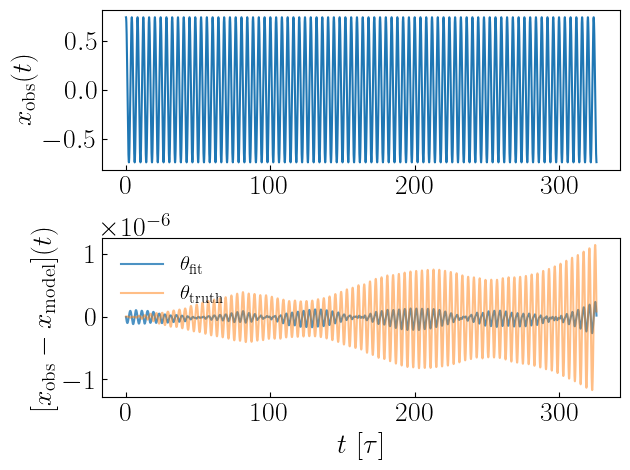

In [864]:
f.plot_x(tmax=-1)

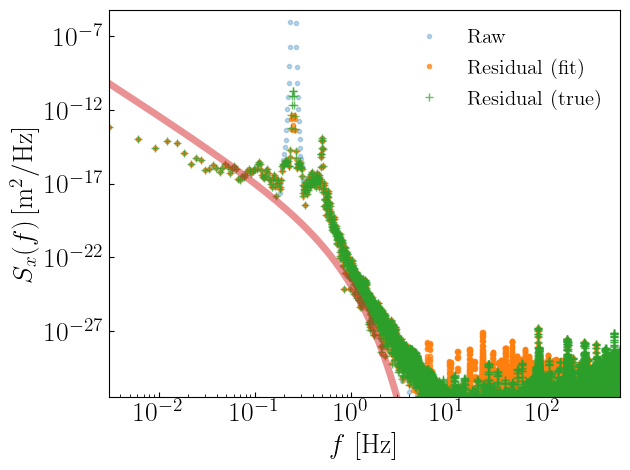

In [853]:
f.plot_position_PS(wd=True, kJ=test.kJ)

In [854]:
freq, PS_a = compute_acc_PS(f.residual, test.dt, wd=True, n=2)
_, PS_a_true = compute_acc_PS(f.x - f.model(true=True), test.dt, wd=True, n=2)

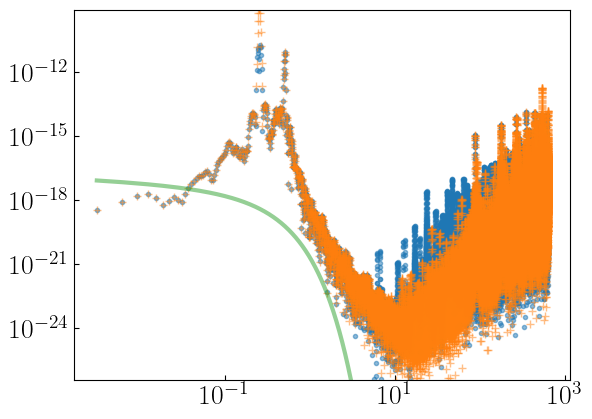

In [855]:
plt.plot(freq, PS_a, '.', alpha=0.5)
plt.plot(freq, PS_a_true, '+', alpha=0.5)
plt.plot(freq, Sa(freq, test.kJ), lw=3, alpha=0.5)

plt.ylim(Sa(3, test.kJ), 1e8 * Sa(freq[1], test.kJ))
plt.xscale('log')
plt.yscale('log')

In [ ]:
a = np.array(test.planet[0]['acc'])[:,0]
b =  - (2 * np.pi / f.P0)**2 * f.x0 * np.cos(f.t0 + 2 * np.pi / f.P0 * test.planet[0]['time'])
# c =  - (2 * np.pi / f.P0True)**2 * f.x0True * np.cos(2 * np.pi / f.P0True * test.planet[0]['time'])
d =  - (2 * np.pi / f.P0)**2 * np.array(test.planet[0]['pos'])[:,0]

In [859]:
fq, ps = compute_PS( (a-b), test.dt, wd=True)
# fq2, ps2 = compute_PS( (a-c), test.dt, wd=True)
fq3, ps3 = compute_PS( (a-d), test.dt, wd=True)

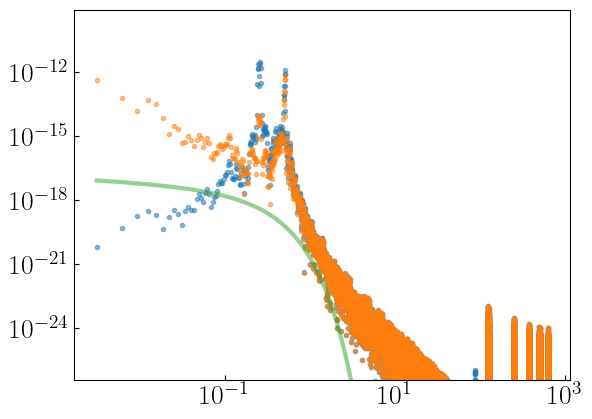

In [860]:
plt.plot(fq, ps, '.', alpha=0.5)
# plt.plot(fq2, ps2, '.', alpha=0.5)
plt.plot(fq3, ps3, '.', alpha=0.5)
plt.plot(freq, Sa(freq, test.kJ), lw=3, alpha=0.5)

plt.ylim(Sa(3, test.kJ), 1e8 * Sa(freq[1], test.kJ))
plt.xscale('log')
plt.yscale('log')

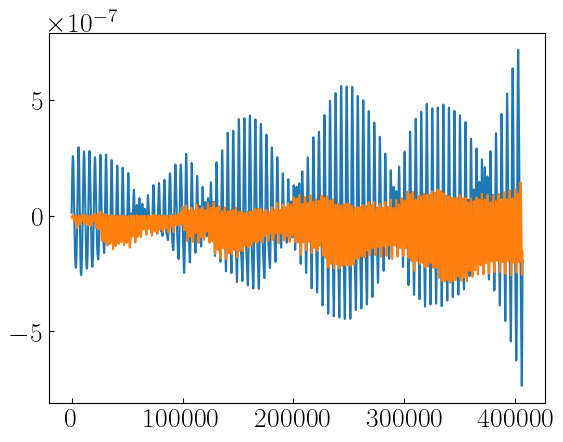

In [861]:
plt.plot((a-b))
# plt.plot((a-c))
plt.plot((a-d))

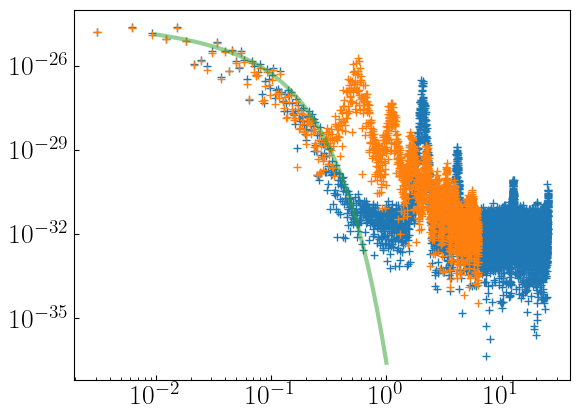

In [85]:
for i in range(len(test.planet)):
    ax = [x[0] for x in np.array(test.planet[i]['acc'])]
    norm = np.array([np.linalg.norm(x) for x in test.planet[i]['pos']])
    x = np.array([x[0] for x in np.array(test.planet[i]['pos'])])
    wd = np.sin(np.pi * test.time[::test.skip_step[i]] / (test.time[-1]))**8 * (128/35)
    a = ax * wd

    b = (ax + test.alpha_sigma * x / norm**3)
    
    # plt.plot(rfftfreq(len(a), test.dt * test.skip_step[i])[1:], 
    #          (test.dt * test.skip_step[i])**2 / test.T * (np.abs(rfftn(a))**2)[1:], '.')
    
    plt.plot(*compute_PS(b, test.dt * test.skip_step[i], wd=False), '+')


f = np.logspace(-2,0)

plt.plot(f, Sa(test.kJ, f, tau=test.skip_step[-1]), lw=3, alpha=0.5)


plt.xscale('log')
plt.yscale('log')